# Households with access to the internet at home

Prepared by [**Erico Farias da Silva**](erico_fariass@hotmail.com)

## Tables needed
- Isoc_r_iacc_h

## Directory

In [1]:
# We save the direc
_THISDIR_ = !pwd
print('Current working directory: %s' % _THISDIR_)

Current working directory: ['/home/erico/git_workspace/istat_2020']


### Settings

Put all libraries/packages/modules/etc... that are necessary so that you can run this notebook.

In [2]:
#try:
#  import google.colab
#  !pip install eurostatapiclient
#except:
#  pass

In [3]:
import requests
import io, os, re, sys
import warnings
import copy, functools
import zipfile

In [4]:
import json

import pandas as pd
pd.set_option('mode.chained_assignment', None) # ignore SettingWithCopyWarning
import numpy as np

In [5]:
try:
    import geopandas as gpd
except ImportError:
    try:
        !{sys.executable} -m pip install geopandas
    except:
        print("! Package geopandas not installed !")
    else:
        print("! Package geopandas installed on-the-fly !")
        import geopandas as gpd
finally:
    warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)

try:
    from shapely import geometry
except ImportError:
    try:
        !{sys.executable} -m pip install shapely
    except:
        print("! Package geopandas not installed !")
    else:
        print("! Package geopandas installed on-the-fly !")
        from shapely import geometry

        
!pip install descartes

In [6]:
try:
    import matplotlib
except ImportError:
    raise IOError("Guess what: you're doomed...")
else:
    import matplotlib.pyplot as mplt
    import matplotlib.dates as mdates
    from matplotlib.ticker import FuncFormatter, MaxNLocator, IndexLocator
finally:
    _FIGSIZE_, _DPI_ = (7,4), 140 # just some default display size/resolution inside this notebook...
%matplotlib inline

In [7]:
try:
    import folium
except ImportError:
    try:
        !{sys.executable} -m pip install folium
    except:
        print("! Package folium not installed !")
    else:
        print("! Package folium installed on-the-fly !")
        import folium
finally:
    from folium import plugins as foliump

try:
    import branca
except ImportError:
    try:
        !{sys.executable} -m pip install branca
    except:
        print("! Package branca not installed !")
    else:
        print("! Package branca installed on-the-fly !")
finally:
    import branca.colormap as bcm

In [8]:
from eurostatapiclient import EurostatAPIClient
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
#from sklearn.linear_model import LinearRegression

legend_properties = {'weight':'bold','size':'12'}
countries_names = {'AT':'Austria', 'BE':'Belgium', 'BG':'Bulgaria', 'CY': 'Cyprus', 'CZ': 'Czechia', 'DE': 'Germany',
                   'DK': 'Denmark', 'EE':'Estonia', 'EL': 'Greece', 'ES':'Spain', 'FI':'Finland', 'FR': 'France',
                   'HR':'Croatia', 'HU':'Hungary', 'IE':'Ireland', 'IT':'Italy', 'LT':'Lithuania', 'LU':'Luxembourg',
                   'LV':'Latvia', 'MT': 'Malta', 'NL':'Netherlands', 'PL':'Poland', 'PT':'Portugal', 'RO':'Romania',
                   'SE':'Sweden', 'SI':'Slovenia', 'SK':'Slovakia', 'EU27_2020': 'EU-27', 'UK':'United Kingdom', 'IS':
                   'Iceland', 'CH': 'Switzerland', 'MK': 'North Macedonia', 'TR': 'Turkey'}
countries_abbr = ['AT','BE','BG','CY','CZ','DE','DK','EE','EL','ES','FI', 'FR','HR','HU','IE','IT','LT','LU','LV',
                  'MT', 'NL', 'PL', 'PT', 'RO', 'SE', 'SI', 'SK', 'EU27_2020', 'UK', 'IS', 'CH', 'MK', 'TR']

Access the data

In [9]:
# Set version, format and language
VERSION = 'v2.1'
FORMAT = 'json'
LANGUAGE = 'en'
# call client
client = EurostatAPIClient(VERSION, FORMAT, LANGUAGE)

In [10]:
# Set colors
c_tot = '#f4c95d'
c_mal = '#f36744'
c_fem = '#134f67'

# style
plt.style.use('fivethirtyeight')

In [11]:
# Set parameters # AGE == 20~64
params = {
    'geoLevel':'nuts1', #'nuts2'?
    'sinceTimePeriod':'2013',
    'precision':'2'
}

dic = {'time' : 'year'}

# GET the data
dataset = client.get_dataset('isoc_r_iacc_h', params=params)
#print(dataset.label)

# Transform into a dataframe
df = dataset.to_dataframe()
df.rename(columns=dic, inplace=True)
df['year'] = df['year'].astype(int)
df = df[df['year']==2019]
print(df.head())


    values   unit  geo  year
6     91.0  PC_HH  AT1  2019
13    86.0  PC_HH  AT2  2019
20    90.0  PC_HH  AT3  2019
27    89.0  PC_HH  BE1  2019
34    92.0  PC_HH  BE2  2019


NUTS Data

We first select the projection that will be used in this exercise. For visualisation purpose, we select the common lat/lon coordinate system (WGS84, or EPSG:4326) as the reference system:

In [12]:
PROJ = 'EPSG:4326'

In [13]:
GISCO_DOMAIN = 'https://gisco-services.ec.europa.eu/distribution/v2/'
NUTS_DOMAIN = 'nuts'

NUTS_YEAR = 2016
NUTS_RES = 20 # 60
NUTS_PROJ = PROJ.split(':')[-1] 
NUTS_FMT = 'geojson' # 'topojson'

nuts_template = 'NUTS_RG_%sM_%s_%s_LEVL_%%s.%s' % (NUTS_RES, NUTS_YEAR, NUTS_PROJ, NUTS_FMT) 
nuts_url = '%s/%s/%s' %  (GISCO_DOMAIN, NUTS_DOMAIN, NUTS_FMT)

#https://gisco-services.ec.europa.eu/distribution/v2/nuts/geojson/NUTS_RG_20M_2021_3857_LEVL_1.geojson
#    'NUTS_RG_%sM_%s_3035_LEVL_%s.%s'

print("Generic URL for NUTS data: \033[1m%s/%s\033[0m (where '%%s' represents a level)" 
      % (nuts_url, nuts_template))

Generic URL for NUTS data: https://gisco-services.ec.europa.eu/distribution/v2//nuts/geojson/NUTS_RG_20M_2016_4326_LEVL_%s.geojson (where '%s' represents a level)


In [14]:
LEVELS = [0,1,2,3]

nuts_files = dict.fromkeys(LEVELS)
nuts_ext = NUTS_FMT

for level in LEVELS:
    nuts_file = nuts_template % level
    nuts_source = '%s/%s' % (nuts_url,nuts_file)
    try : 
        dest = os.path.join(_THISDIR_[0], nuts_file)
        assert os.path.exists(dest)
    except:
        try:
            !wget -O $dest "$nuts_source"
            #!mkdir $nuts_dir
            #!unzip -u -d $nuts_dir $nuts_source        
        except:
            raise IOError("Error fetching the data...")
        else:
            print('Data loaded on disk in directory: \033[1m%s\033[0m' % dest)
    else:
        print('Data already loaded on disk in directory: \033[1m%s\033[0m' % dest)
    finally:
        nuts_files.update({level: nuts_file}) # dest

Data already loaded on disk in directory: /home/erico/git_workspace/istat_2020/NUTS_RG_20M_2016_4326_LEVL_0.geojson
Data already loaded on disk in directory: /home/erico/git_workspace/istat_2020/NUTS_RG_20M_2016_4326_LEVL_1.geojson
Data already loaded on disk in directory: /home/erico/git_workspace/istat_2020/NUTS_RG_20M_2016_4326_LEVL_2.geojson
Data already loaded on disk in directory: /home/erico/git_workspace/istat_2020/NUTS_RG_20M_2016_4326_LEVL_3.geojson


In [15]:
# We 'store' one vector dataset per NUTS level (nuts_data)

DRIVERS = {'geojson': 'GeoJSON',
          'shp': 'ESRI Shapefile'}

nuts_data = dict.fromkeys(LEVELS)
[nuts_data.update({l: gpd.read_file(os.path.join(_THISDIR_[0], nuts_files[l]), 
                                    driver=DRIVERS[NUTS_FMT])}) 
 for l in LEVELS]

print("Geographical datasets: \033[1m%s\033[0m loaded" % list(nuts_files.values()))
print("Projection: \033[1m%s\033[0m" % nuts_data[LEVELS[0]].crs)

nuts_data[LEVELS[0]].sample(5)

Geographical datasets: ['NUTS_RG_20M_2016_4326_LEVL_0.geojson', 'NUTS_RG_20M_2016_4326_LEVL_1.geojson', 'NUTS_RG_20M_2016_4326_LEVL_2.geojson', 'NUTS_RG_20M_2016_4326_LEVL_3.geojson'] loaded
Projection: epsg:4326


,id,COAST_TYPE,MOUNT_TYPE,CNTR_CODE,FID,NUTS_ID,NUTS_NAME,LEVL_CODE,URBN_TYPE,geometry
3,FR,0,0,FR,FR,FR,FRANCE,0,0,"(POLYGON ((2.60704 50.91269, 2.64799 50.82501,..."
19,PT,0,0,PT,PT,PT,PORTUGAL,0,0,"(POLYGON ((-8.16508 41.8183, -8.05186 41.82061..."
7,AT,0,0,AT,AT,AT,ÖSTERREICH,0,0,"POLYGON ((15.75363 48.85218, 16.29009 48.73395..."
36,NO,0,0,NO,NO,NO,NORGE,0,0,"(POLYGON ((28.92968 69.0519, 28.8195 69.126499..."
14,DK,0,0,DK,DK,DK,DANMARK,0,0,"(POLYGON ((10.19436 56.68466, 10.30688 56.6801..."


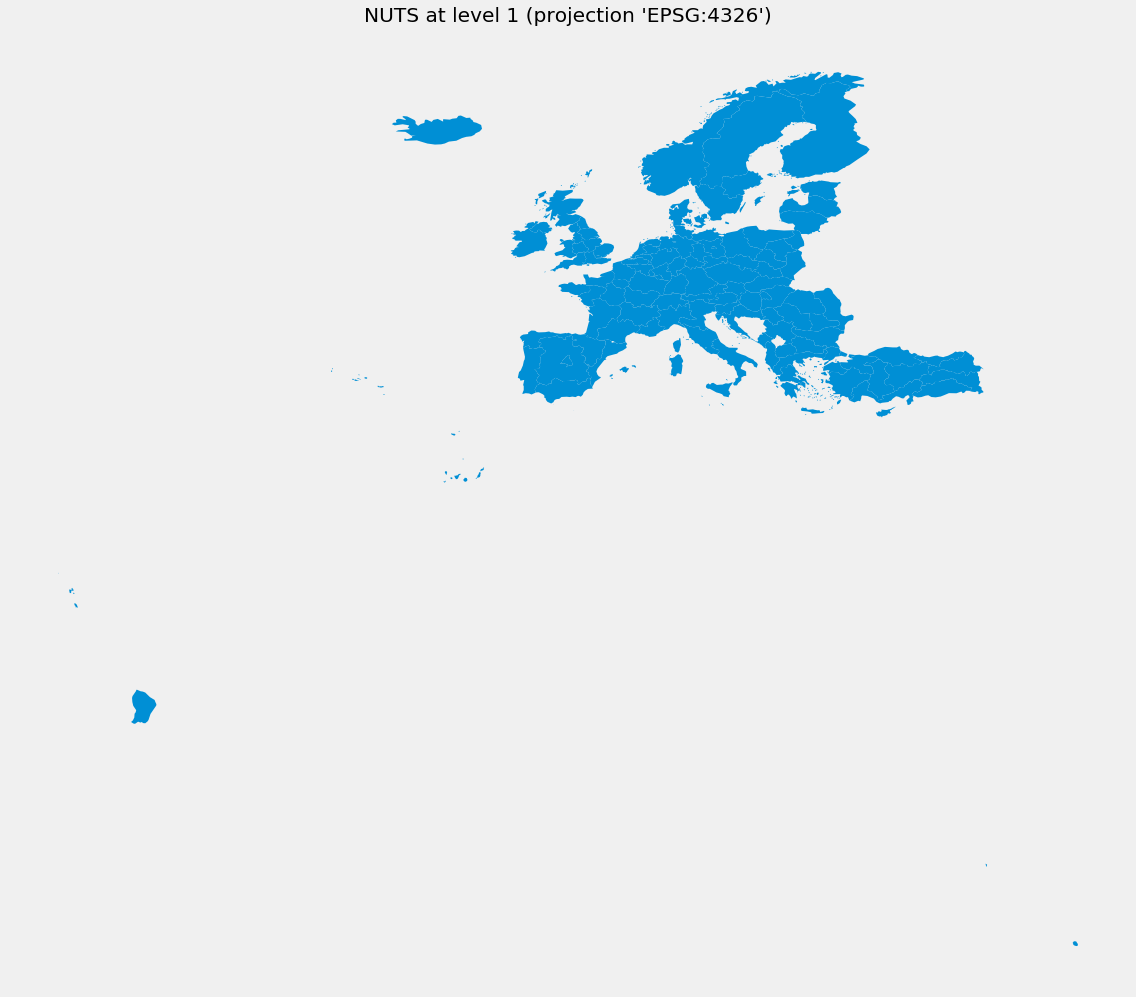

In [16]:
# Visualize the map without data

level = LEVELS[1]

f, ax = mplt.subplots(1, figsize=(16, 16))
nuts_data[level].plot(ax=ax)
ax.axes.get_xaxis().set_visible(False); ax.axes.get_yaxis().set_visible(False)
ax.set_title("NUTS at level %s (projection 'EPSG:%s')" % (level,NUTS_PROJ)) 
f.tight_layout()
mplt.show()

In [17]:
KEY = 'NUTS_ID'

NUTS_ID = dict.fromkeys(LEVELS)
CTRY_ID = dict.fromkeys(LEVELS) 

for l in LEVELS:
    NUTS_ID.update({l: nuts_data[l][KEY].unique().tolist()})
    CTRY_ID.update({l: list(set([_id[:2] for _id in NUTS_ID[l]]))})
    
DATA_NUTS_ID = dict.fromkeys(LEVELS) 
all_id = df['geo'].unique().tolist()

print('Data are availalble:') 
for l in LEVELS:
    DATA_NUTS_ID.update({l: list(set([_id[:2] for _id in all_id if len(_id)==l+2]))})
    print('* NUTS level %s: \033[1m%s\033[0m' 
          % (l, DATA_NUTS_ID[l]))

Data are availalble:
* NUTS level 0: []
* NUTS level 1: ['PL', 'TR', 'AT', 'CH', 'LT', 'LU', 'CY', 'CZ', 'MK', 'RS', 'SK', 'EE', 'BE', 'DE', 'IE', 'FR', 'MT', 'ES', 'SE', 'HU', 'LV', 'FI', 'NO', 'PT', 'IT', 'NL', 'RO', 'HR', 'UK', 'DK', 'SI', 'BG', 'IS', 'EL']
* NUTS level 2: []
* NUTS level 3: []


In [18]:
MISSING_CTRY_ID = dict.fromkeys(LEVELS) 

print('Data are NOT availalble:') 
for l in LEVELS:
    MISSING_CTRY_ID.update({l: list(set(CTRY_ID[l]).difference(set(DATA_NUTS_ID[l])))})
    print('* NUTS level %s: \033[1m%s\033[0m' 
          % (l, MISSING_CTRY_ID[l]))

Data are NOT availalble:
* NUTS level 0: ['ME', 'PL', 'TR', 'AT', 'CH', 'LT', 'LU', 'CY', 'AL', 'MK', 'CZ', 'RS', 'SK', 'EE', 'BE', 'DE', 'IE', 'FR', 'MT', 'ES', 'SE', 'HU', 'LV', 'FI', 'NO', 'PT', 'IT', 'RO', 'LI', 'NL', 'HR', 'UK', 'DK', 'SI', 'BG', 'IS', 'EL']
* NUTS level 1: ['ME', 'LI', 'AL']
* NUTS level 2: ['ME', 'PL', 'TR', 'AT', 'CH', 'LT', 'LU', 'CY', 'CZ', 'MK', 'AL', 'RS', 'SK', 'EE', 'DE', 'BE', 'IE', 'FR', 'MT', 'ES', 'SE', 'HU', 'LV', 'FI', 'NO', 'PT', 'IT', 'LI', 'NL', 'RO', 'HR', 'UK', 'DK', 'SI', 'BG', 'IS', 'EL']
* NUTS level 3: ['ME', 'PL', 'TR', 'AT', 'CH', 'LT', 'LU', 'CY', 'AL', 'MK', 'CZ', 'RS', 'SK', 'EE', 'DE', 'BE', 'IE', 'FR', 'MT', 'ES', 'SE', 'HU', 'LV', 'FI', 'NO', 'PT', 'IT', 'NL', 'LI', 'RO', 'UK', 'HR', 'DK', 'SI', 'BG', 'IS', 'EL']


In [19]:
# Prepare dataframe to merge the NUTS DATA
df.rename(columns = {'geo':'NUTS_ID'}, inplace = True)
df.head(n = 5)

,values,unit,NUTS_ID,year
6,91.0,PC_HH,AT1,2019
13,86.0,PC_HH,AT2,2019
20,90.0,PC_HH,AT3,2019
27,89.0,PC_HH,BE1,2019
34,92.0,PC_HH,BE2,2019


In [20]:
# We merge NUTS_Data and df
region_data = nuts_data[LEVELS[1]]

# Merge on NUTS_ID
result = pd.merge(region_data, df, how = 'inner', on = 'NUTS_ID') 
result.head()

,id,COAST_TYPE,MOUNT_TYPE,CNTR_CODE,FID,NUTS_ID,NUTS_NAME,LEVL_CODE,URBN_TYPE,geometry,values,unit,year
0,PT2,0,0,PT,PT2,PT2,REGIÃO AUTÓNOMA DOS AÇORES,1,0,"(POLYGON ((-25.6919 37.84324, -25.58586 37.814...",86.0,PC_HH,2019
1,BE1,0,0,BE,BE1,BE1,RÉGION DE BRUXELLES-CAPITALE/BRUSSELS HOOFDSTE...,1,0,"POLYGON ((4.28308 50.81361, 4.28883 50.8918, 4...",89.0,PC_HH,2019
2,BE2,0,0,BE,BE2,BE2,VLAAMS GEWEST,1,0,"(POLYGON ((4.75993 51.50246, 4.864 51.43362, 5...",92.0,PC_HH,2019
3,BE3,0,0,BE,BE3,BE3,RÉGION WALLONNE,1,0,"(POLYGON ((5.682 50.75745, 5.81905 50.71456, 5...",87.0,PC_HH,2019
4,BG3,0,0,BG,BG3,BG3,СЕВЕРНА И ЮГОИЗТОЧНА БЪЛГАРИЯ,1,0,"POLYGON ((22.99717 43.80787, 23.40948 43.84985...",73.0,PC_HH,2019


In [21]:
# creating bool series True for NaN values  
bool_series = pd.isnull(df["values"])  

# filtering data  
# displaying data only with Gender = NaN  
df[bool_series]  

,values,unit,NUTS_ID,year
209,NaN,PC_HH,EL1,2019
216,NaN,PC_HH,EL2,2019
307,NaN,PC_HH,FI2,2019
559,NaN,PC_HH,PL1,2019
573,NaN,PC_HH,PL3,2019


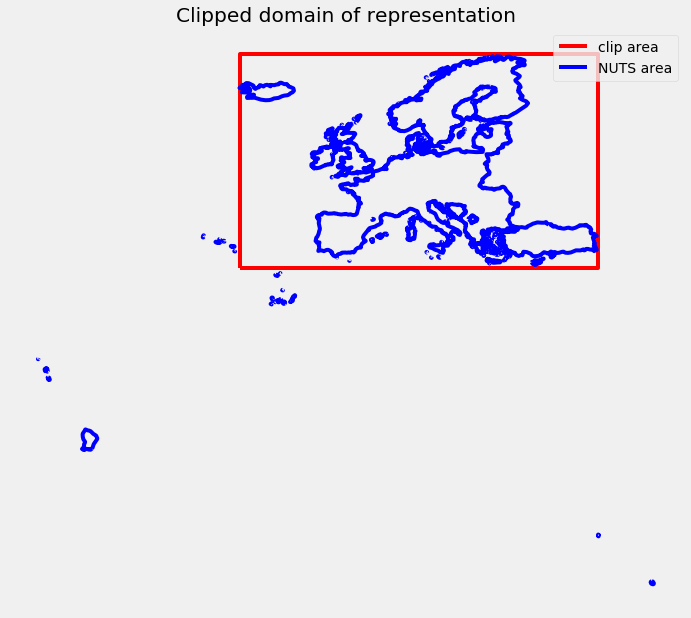

In [52]:
EUmask = geometry.Polygon([#w: -25.5, s:35, e:30.2, n:71.3 in EPSG:4326 system
                         (-24, 34),
                         (45, 34),
                         (45,  71.5),
                         (-24, 71.5)
])
EUclip = gpd.GeoDataFrame(index=[0], geometry=[EUmask], crs=PROJ)

NUTSarea = gpd.GeoDataFrame(index=[0], geometry=[nuts_data[0].unary_union], crs=PROJ)


f, ax = mplt.subplots(1, figsize=(16, 10))
EUclip.boundary.plot(ax=ax, color='r', label='clip area')
NUTSarea.boundary.plot(ax=ax, color='b', label='NUTS area')
ax.axes.get_xaxis().set_visible(False); ax.axes.get_yaxis().set_visible(False)
ax.set_title('Clipped domain of representation')
ax.legend()
mplt.show()

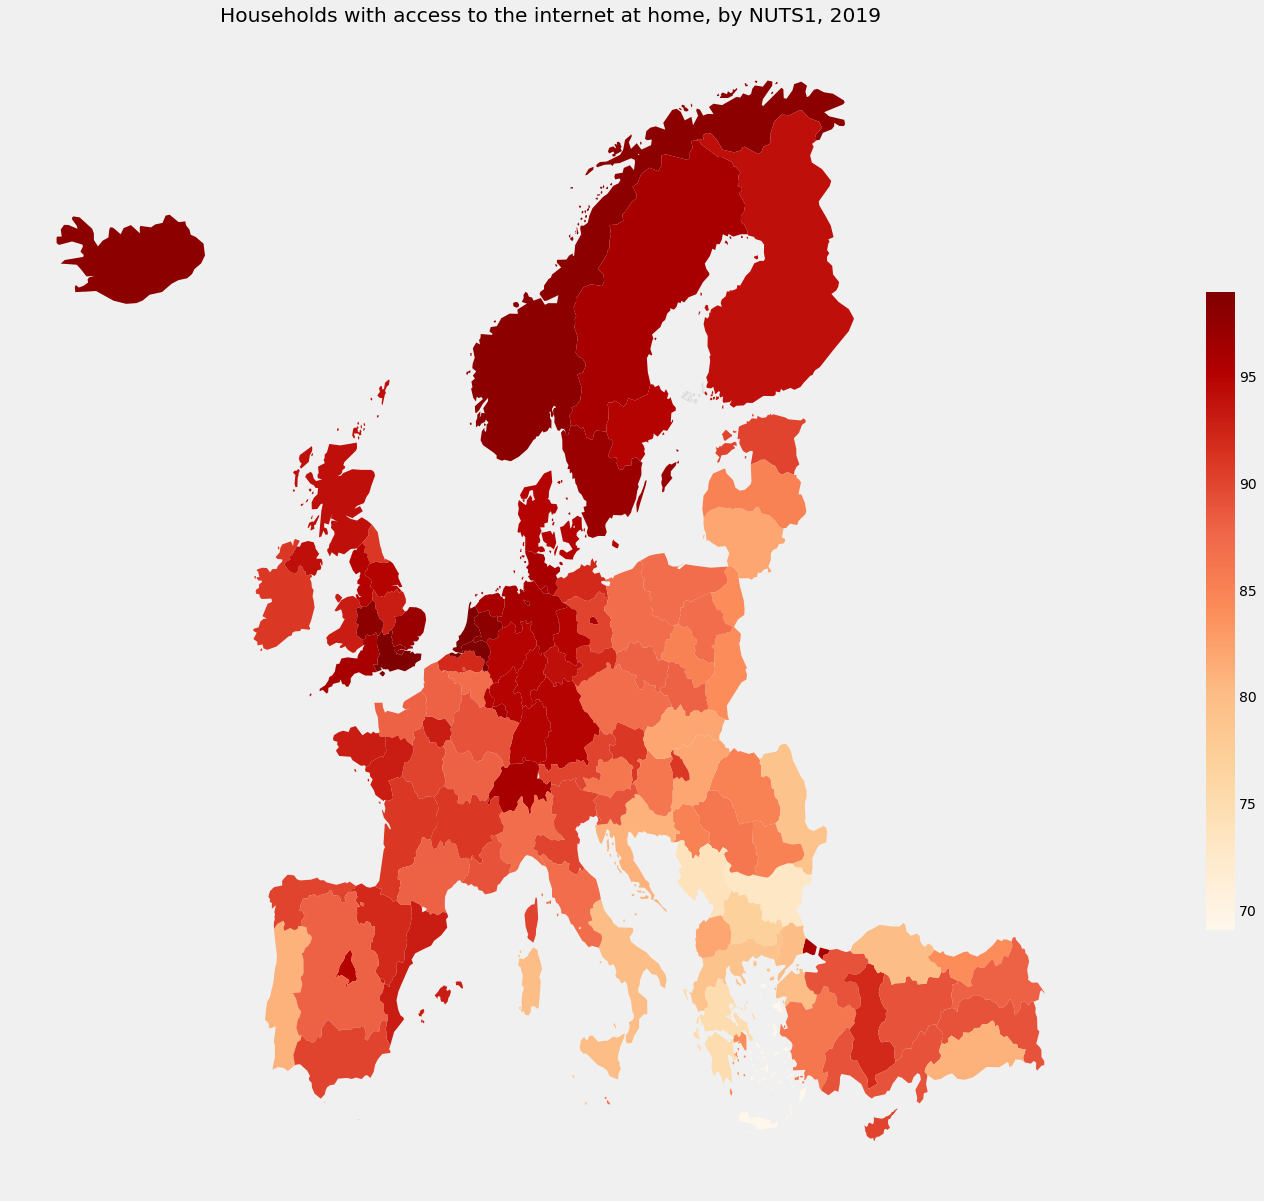

In [68]:
#LEVEL = 1
crop = gpd.clip(result, EUclip)

f, ax = mplt.subplots(1, figsize=(35, 20))
crop.plot(column='values', ax=ax, cmap='OrRd', legend=True,
          legend_kwds = {'shrink':0.55},
          missing_kwds={ "color": "lightgrey", "alpha": 0.2, "edgecolor": "grey", "hatch": "///"}
         )
ax.set_axis_off()
ax.set_title('Households with access to the internet at home, by NUTS1, 2019')
# f.tight_layout()
# f.subplots_adjust(hspace=0,wspace=-1)
mplt.show()

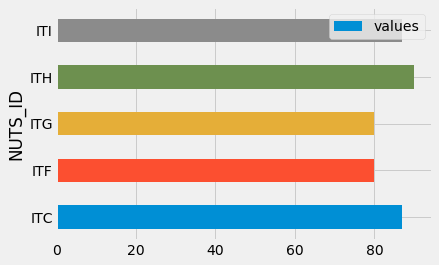

In [24]:
italy_internet = df[df['NUTS_ID'].str.startswith('IT')]

italy_internet.plot('NUTS_ID', 'values', kind='barh')

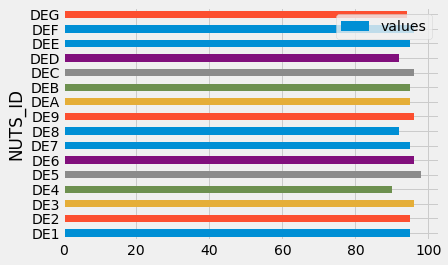

In [25]:
germany_internet = df[df['NUTS_ID'].str.startswith('DE')]

germany_internet.plot('NUTS_ID', 'values', kind='barh')

In [ ]:
%lsmagic